<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-пункту-1" data-toc-modified-id="Выводы-по-пункту-1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы по пункту 1</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-пункту-2" data-toc-modified-id="Выводы-по-пункту-2-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы по пункту 2</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Дополнение" data-toc-modified-id="Дополнение-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дополнение</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-пункту-3,-4" data-toc-modified-id="Выводы-по-пункту-3,-4-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы по пункту 3, 4</a></span></li></ul></li><li><span><a href="#Выводы-по-проекту" data-toc-modified-id="Выводы-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы по проекту</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings


## Подготовка

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Монотонный ли индекс: True


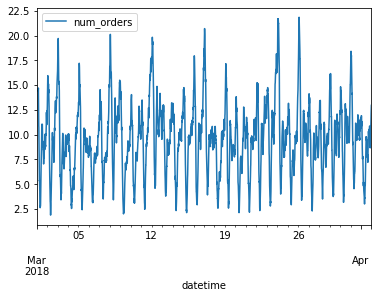

In [2]:
warnings.filterwarnings('ignore')
taxi = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
taxi.info()
display(taxi.head())
print('Монотонный ли индекс:', taxi.index.is_monotonic)
taxi['2018-03-01':'2018-04-01'].rolling(24).mean().plot()
taxi = taxi.resample('1H').sum()

### Выводы по пункту 1

В ходе выполнения первого пункта было произведено преобразование таблицы в датасет с выделением столбца с датами в качестве индекса и приведением его к соответствующему формату для удобства дальнейшего преобразования признаков. Проведен анализ содержащихся данных временного ряда, а также произведено ресемплирование данных до 1 часа, проверена монотонность индекса.    

## Анализ

count    744.000000
mean      57.483871
std       29.562439
min        1.000000
25%       39.000000
50%       55.000000
75%       75.000000
max      182.000000
Name: num_orders, dtype: float64
count    744.000000
mean     127.651882
std       56.242228
min       13.000000
25%       91.000000
50%      122.000000
75%      160.000000
max      462.000000
Name: num_orders, dtype: float64


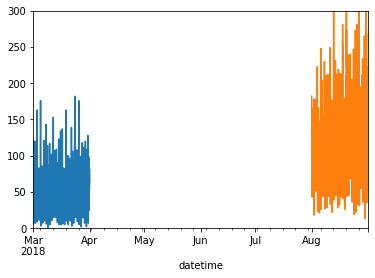

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 4 columns):
num_orders    4416 non-null int64
dayofweek     4416 non-null int64
hour          4416 non-null int64
month         4416 non-null int64
dtypes: int64(4)
memory usage: 172.5 KB


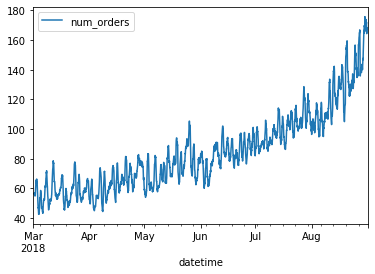

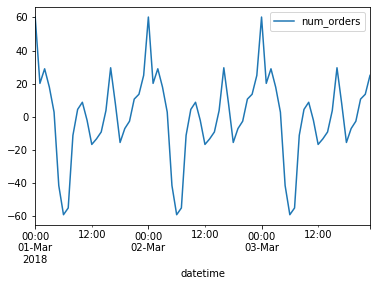

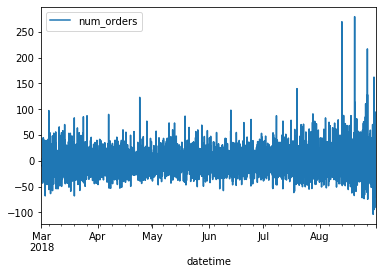

In [3]:
print(taxi['2018-03-01':'2018-03-31']['num_orders'].describe())
print(taxi['2018-08-01':'2018-08-31']['num_orders'].describe())
taxi['2018-03-01':'2018-03-31']['num_orders'].plot()
taxi['2018-08-01':'2018-08-31']['num_orders'].plot()
plt.ylim(0,300)
plt.show()
decomposed = seasonal_decompose(taxi)
decomposed.trend.plot() 
decomposed.seasonal.head(72).plot() 
decomposed.resid.plot()
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
taxi['month'] = taxi.index.month
def make_features(data, max_lag, rolling_mean_max_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_max_size).mean()        
    return data
#make_features(taxi,2,2)
taxi = taxi.dropna()
taxi.info()

### Выводы по пункту 2

В ходе данного пункта произведен анализ имеющегося датасета. Данные разложены на трендовую, сезонную и шумовую компоненты. Стоит отметить, то тренд к увеличению количества заказов в час наблюдается в течение всего представленного периода, при этом отклонения в течение суток сильно не меняются. Сезонная компонента наиболее ярким образом заметна в течение суток при разбивке по часам. Всплески видны утром, вечером (в конце рабочего дня), и поздним вечером. При этом практически отсутствуют заказы после полуночи и до раннего утра. Шумовая составляющая проявляется незначительно сильнее к августу месяц, что у связано скорее всего с увеличением общего числа поездок во временной интервал времени. В качетве подготовки к обучению выделены признаки даты (день месяца, день недели, месяц, час). Также определена функция, формирующая признак n-сдвигов и сумму значений скользящего окна размером m (реализовать удаление строк с Nan в функции не получилось).   

## Обучение

In [4]:
%%time
def optims_features (data, max_shuffle, max_roll):
    list_RMSE = []
    list_forest_RMSE = []
    list_forest_best_param_RMSE = []
    for s in range(1, max_shuffle+1):
        for r in range(1, max_roll+1):
            make_features (data, s, r)
            data_1 = data.dropna()
                
            target = data_1['num_orders']
            features = data_1.drop('num_orders', axis = 1)
            feature_train, feature_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1, random_state = 12345)
            #display(target_test.head(10))
            #feature_train.info()
            model = LinearRegression()
            model.fit(feature_train, target_train)
            predict_train = model.predict(feature_train) 
            predict_test = model.predict(feature_test)
            
            
            #print("RMSE обучающей выборки:", (mean_squared_error(target_train, predict_train))**0.5)# < напишите код здесь >)
            #print("RMSE тестовой выборки: ", (mean_squared_error(target_test, predict_test))**0.5)# < напишите код здесь >)
            list_RMSE.append((mean_squared_error(target_test, predict_test))**0.5)
            
            model_1 = RandomForestRegressor()
            smape_scorerrr = make_scorer(mean_squared_error, greater_is_better=False)
            grid = GridSearchCV(estimator = model_1,
                                param_grid={'n_estimators': [i for i in range(1, 5)], 'max_depth' : [c for c in range(1, 10)],
                                           'random_state': [12345]},
                                scoring = smape_scorerrr, cv = 5) 
            model = grid.fit(feature_train, target_train)
            #print(grid.best_params_)
            #print("Для случайного леса наилучшее значение RSME", (abs(grid.best_score_))**0.5,'достигается при', grid.best_params_)
            #print("---------------------------------------------")
            model = grid.fit(feature_test, target_test)
            #print("Для случайного леса по тестовым данным значение RSME", (abs(grid.best_score_))**0.5)
            #print("---------------------------------------------")
            list_forest_RMSE.append((abs(grid.best_score_))**0.5)
            list_forest_best_param_RMSE.append(grid.best_params_)
    print(min(list_RMSE))
    print(list_RMSE.index(min(list_RMSE)))
    print(min(list_forest_RMSE))
    c = list_forest_RMSE.index(min(list_forest_RMSE))
    print(c)
    print('лучшие параметры для модели на основе алгоритма случайного леса',list_forest_best_param_RMSE[c])              
    return data_1
optims_features (taxi, 5, 5)

53.3712461123815
11
41.87305474502493
5
лучшие параметры для модели на основе алгоритма случайного леса {'max_depth': 7, 'n_estimators': 4, 'random_state': 12345}
CPU times: user 2min 30s, sys: 2.78 s, total: 2min 32s
Wall time: 2min 33s


,num_orders,dayofweek,hour,month,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,
2018-03-01 05:00:00,6,3,5,3,43.0,77.8,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,3,6,3,6.0,54.2,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,3,7,3,12.0,39.6,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,3,8,3,15.0,28.4,12.0,6.0,43.0,66.0
2018-03-01 09:00:00,69,3,9,3,34.0,22.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,8,207.0,174.0,217.0,197.0,116.0,133.0
2018-08-31 20:00:00,154,4,20,8,136.0,174.6,207.0,217.0,197.0,116.0
2018-08-31 21:00:00,159,4,21,8,154.0,182.2,136.0,207.0,217.0,197.0


### Дополнение

,target_test,predicted
datetime,,
2018-08-13 14:00:00,102,103.811439
2018-08-13 15:00:00,175,110.817038
2018-08-13 16:00:00,144,103.811439
2018-08-13 17:00:00,152,110.817038
2018-08-13 18:00:00,104,95.214962


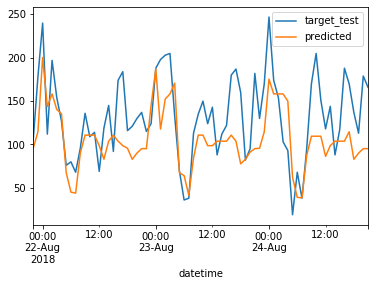

In [5]:
make_features (taxi, 5, 1)
data_1 = taxi.dropna()                
target = data_1['num_orders']
features = data_1.drop('num_orders', axis = 1)
feature_train, feature_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1, random_state = 12345)
model_plot = RandomForestRegressor( max_depth = 7, n_estimators = 4, random_state = 12345)
model_plot.fit(feature_train, target_train)
predicted = model_plot.predict(feature_test)
target_test_1 = pd.DataFrame(data = target_test, index = target_test.index, columns = ['target_test','predicted'])
target_test_1['predicted'] = predicted
target_test_1['target_test'] = target_test
display(target_test_1.head())
target_test_1.iloc[200:272].plot()
plt.show()

## Тестирование

### Выводы по пункту 3, 4

В пункте 3 реализована функция использующая результат работы функции 'make_features' по перебору признаков и проверяющая качество работы моделей линейной регрессии и случайного леса с различными параметрами на тренировочной и тестовой выборках для предсказания количества необходимых таксистов на следующий час. В результате на наилучшее значение RSME (41.873) на тестовой выборке показал лес с параметрами максимальной глубины дерева 7 и количеством деревьев равным 4. При этом наилучшее значение для признаков оказалось 1 сдвиг и размер скользящего окна равный 5. Для линейной регрессии наилучшее значение метрики оказалось равным 53.371 при характеристиках признаков 3 сдвига и 2 - размер скользящего окна. В итоге наилушее значение RMSE меньше требуемого (48).   

## Выводы по проекту

В ходе выполенения данного проекта предсказано значение целевой величины на основе данного временного ряда (заказов такси на следующий час). Произведен первичный анализ данных, их соответсвующее преобразование, выделение признаков, необходимых для последующего предсказания.Также выделены и проанализированы сезонная и трендовые компоненты временного ряда. Реализованы 2 функции: по подбору признаков скользящего окна и сдвигов, по подбору параметров случайного леса для каждого набора признаков и определния качества работы моделей на тестовых данных. В итоге наилучшее значение метрики для тестовых данных у  модели случайного леса дало значение 41.1213, что меньше (48) требуемого почти на 15%. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [X]  Модель обучена, гиперпараметры подобраны
- [X]  Качество моделей проверено, выводы сделаны
- [X]  Значение *RMSE* на тестовой выборке не больше 48